# FCR-D Analysis of Price and volumes

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import requests


## Run API
If you haven't loaded this before run the API. It will take a little bit to run depending on your computer. (Took me 2 min)
Otherwise if already run before save it in a CSV file and load that file instead.

In [2]:

# This is an API call for FCR-D up and the price areas DK2, SE1 ... SE4

# Check the link for how to "manually" download it.

# https://www.energidataservice.dk/tso-electricity/FcrNdDK2

start_date = "2022-01-01"
end_date = "2023-03-31"
limit = "1000000" # Set limit

ColumnsFCRv2_all = "HourDK, ProductName, PriceArea,AuctionType, PurchasedVolumeLocal, PurchasedVolumeTotal, PriceTotalEUR"
    
# AuctionType = {D-1, D-2 or Total}
# ProductName = {FCR-D upp, FCR-D ned, FCR-N}

dictFilter = {"PriceArea": ("DK2","SE1","SE2","SE3","SE4"),"ProductName": ("FCR-D upp", "FCR-D ned", "FCR-N"),"AuctionType": ("Total", "D-1","D-2")} # To apply filter transform into dict -> json
jsonFilter = json.dumps(dictFilter)
parametersFCRD= {
    "start": start_date,
    "end": end_date,
    "columns": ColumnsFCRv2_all,
    "filter": jsonFilter,
    "limit": limit
    }
response = requests.get(
    url='https://api.energidataservice.dk/dataset/FcrNdDK2', params=parametersFCRD)

result = response.json() # Change to JSON file
records_data = result['records'] # extract the 'records' data
df = pd.DataFrame(records_data) # convert the 'records' data to a pandas DataFrame


print(df)
df.to_csv('FCR_Energinet_Data.csv', index=False) # save the DataFrame as a CSV file
#df = df.loc[::-1]




KeyboardInterrupt: 

## Load CSV file
If API has already been runned, load the csv instead. 1 second versus 2 minutes ;-) 

In [2]:
df = pd.read_csv('FCR_Energinet_Data.csv') # Change path
pd.to_datetime(df["HourDK"]) # Convert HourDK to datetimeprint(df), such that one can use it to index


0        2023-03-30 23:00:00
1        2023-03-30 23:00:00
2        2023-03-30 23:00:00
3        2023-03-30 23:00:00
4        2023-03-30 23:00:00
                 ...        
490270   2022-01-01 00:00:00
490271   2022-01-01 00:00:00
490272   2022-01-01 00:00:00
490273   2022-01-01 00:00:00
490274   2022-01-01 00:00:00
Name: HourDK, Length: 490275, dtype: datetime64[ns]

Check if the summation of all the price areas (except DK1) gives the same as Total

In [3]:
# Is total the same as the summation of DK2, SE1 to SE4?'
lstPriceArea = ["SE1","SE2","SE3","SE4"]
mask = (df["PriceArea"] == "DK2") & (df["AuctionType"] == "Total") & (df["ProductName"] == "FCR-D upp")
sum_pa = df["PurchasedVolumeLocal"].loc[mask].reset_index(drop=True)
for pa in lstPriceArea:
    temp_mask = (df["PriceArea"] == pa) & (df["AuctionType"] == "Total") & (df["ProductName"] == "FCR-D upp")
    sum_pa = sum_pa + df["PurchasedVolumeLocal"].loc[temp_mask].reset_index(drop=True)

print(sum_pa) 
print(df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True))


0        603.3
1        617.3
2        619.2
3        598.3
4        598.3
         ...  
10890    455.2
10891    456.4
10892    465.4
10893    457.7
10894    469.4
Name: PurchasedVolumeLocal, Length: 10895, dtype: float64
0        603.3
1        617.3
2        619.2
3        598.3
4        598.3
         ...  
10890    455.2
10891    456.4
10892    465.4
10893    457.7
10894    469.4
Name: PurchasedVolumeTotal, Length: 10895, dtype: float64


In [7]:
product_names = ["FCR-D upp","FCR-D ned"]
#product_names = ["FCR-D ned"]
auction_type = "Total"
price_areas = ["DK2", "SE1", "SE2", "SE3", "SE4"]
area = "DK2"
auction_types = ["D-1","D-2","Total"]
Latest_time = '2023-03-31T00:00:00'
Earliest_time = '2022-01-01T00:00:00'
pd.to_datetime(Latest_time)
pd.to_datetime(Earliest_time)
for auction_type in auction_types:
    for product_name in product_names:
        mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == area) & (df["AuctionType"] == auction_type) & (df["ProductName"] == product_name)

        volume = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)
        zero_or_lower_indexes = volume.loc[volume <= 0].index
        print("For " ,auction_type," in ",product_name," ",zero_or_lower_indexes)


For  D-1  in  FCR-D upp   Index([], dtype='int64')
For  D-1  in  FCR-D ned   Index([], dtype='int64')
For  D-2  in  FCR-D upp   Index([], dtype='int64')
For  D-2  in  FCR-D ned   Index([], dtype='int64')
For  Total  in  FCR-D upp   Index([], dtype='int64')
For  Total  in  FCR-D ned   Index([], dtype='int64')


## Plot procurement graphs

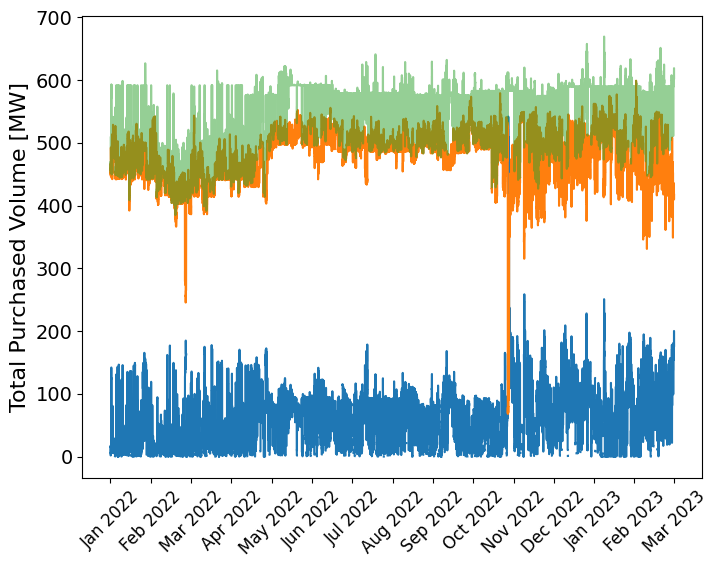

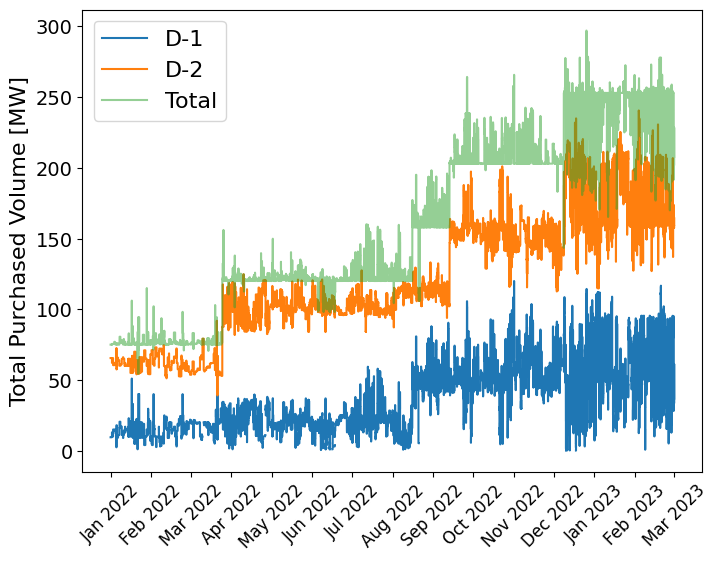

In [30]:
product_names = ["FCR-D upp","FCR-D ned"]
#product_names = ["FCR-D ned"]
auction_type = "Total"
price_areas = ["DK2", "SE1", "SE2", "SE3", "SE4"]
area = "DK2"
auction_types = ["D-1","D-2","Total"]
Latest_time = '2023-03-31T00:00:00'
Earliest_time = '2022-01-01T00:00:00'
pd.to_datetime(Latest_time)
pd.to_datetime(Earliest_time)



for i, product_name in enumerate(product_names):
    # Create a Figure with two subplots
    fig, axs = plt.subplots(figsize=(8, 6), dpi=100)

    ax = axs

    for auction_type in  auction_types:
        mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == area) & (df["AuctionType"] == auction_type) & (df["ProductName"] == product_name)

        volume = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)
        volume = volume.loc[::-1].reset_index(drop=True)
        if auction_type == "Total":
            ax.plot(volume, label=f"{auction_type}", drawstyle='steps-post',alpha = 0.5)
        else:
            ax.plot(volume, label=f"{auction_type}", drawstyle='steps-post')

    mask_total = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == "DK2") & (df["AuctionType"] == auction_type) & (df["ProductName"] == product_name)
    xaxis = df["HourDK"].loc[mask_total].reset_index(drop=True)
    xaxis = xaxis.loc[::-1].reset_index(drop=True)

    xaxis = pd.to_datetime(xaxis)# Convert xaxis to datetime

    # Set the x-axis ticks to be monthly
    num_ticks = len(xaxis)
    tick_step = max(1, int(np.ceil(num_ticks / 14))) # Show at least one tick per month
    month_ticks = xaxis.index % tick_step == 0
    if not month_ticks[0]:
        month_ticks[0] = True
    if not month_ticks[-1]:
        month_ticks[-1] = True
    #ax.xticks(xaxis.index[month_ticks], xaxis[month_ticks].dt.strftime("%Y - %b"), rotation=45)

    #ax.grid(linestyle='--', color='gray')
    ax.set_xticks(xaxis.index[month_ticks])

    ax.tick_params(axis='y', which='major', labelsize=14)

    
    ax.set_xticklabels(xaxis[month_ticks].dt.strftime("%b %Y"), rotation=45, fontsize=12)

    #ax.set_title(product_name)
    if product_name == "FCR-D ned":
        axs.legend(bbox_to_anchor=(0, 1), loc='upper left',prop={'size': 16})

    axs.set_ylabel("Total Purchased Volume [MW]", fontsize=16)
    plt.savefig('Total_volume_FCR_D'+ product_name +'.pdf', format="pdf", bbox_inches="tight")
    plt.show()




What is the averages?


In [14]:
price_areas = "DK2"
product_name = "FCR-D upp"
auction_type = "Total"
Latest_time = '2022-12-31T00:00:00'
Earliest_time = '2022-01-01T00:00:00'
pd.to_datetime(Latest_time)
pd.to_datetime(Earliest_time)

mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == price_areas) & (df["AuctionType"] == auction_type) & (df["ProductName"] == product_name)
volume_DK2 = df["PurchasedVolumeLocal"].loc[mask].reset_index(drop=True)
volume_total = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)

print("Average Procurement in all the price areas: ",np.average(volume_total))
print("Average Procurement in DK2: ",np.nanmean(volume_DK2))


Average Procurement in all the price areas:  529.4000343367289
Average Procurement in DK2:  21.85917840375587


In [15]:
price_areas = "DK2"
product_name = "FCR-D upp"
product_name = "FCR-D ned"
auction_type = "Total"
Latest_time = '2023-03-31T00:00:00'
Earliest_time = '2022-01-01T00:00:00'
pd.to_datetime(Latest_time)
pd.to_datetime(Earliest_time)

mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == price_areas) & (df["AuctionType"] == "Total") & (df["ProductName"] ==  product_name)
volume_total = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)
print(volume_total.head())
mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == price_areas) & (df["AuctionType"] == "D-1") & (df["ProductName"] ==  product_name)
volume_D_1 = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)

mask = (df["HourDK"] >= Earliest_time) & (df["HourDK"] <= Latest_time) & (df["PriceArea"] == price_areas) & (df["AuctionType"] == "D-2") & (df["ProductName"] ==  product_name)
volume_D_2 = df["PurchasedVolumeTotal"].loc[mask].reset_index(drop=True)

mean_percentage_D_1 = np.mean((volume_D_1)/volume_total)
mean_percentage_D_2 = np.mean((volume_D_2)/volume_total)

print(mean_percentage_D_1)
print(mean_percentage_D_2)
print(mean_percentage_D_2+mean_percentage_D_1)
print("Average Procurement in all the price areas: ",np.average(volume_total))
print("Average Procurement in DK2: ",np.nanmean(volume_DK2))


0    207.8
1    228.5
2    208.3
3    201.8
4    201.8
Name: PurchasedVolumeTotal, dtype: float64
0.21660375425623976
0.7864601681398203
1.00306392239606
Average Procurement in all the price areas:  156.52636071592474
Average Procurement in DK2:  21.85917840375587


# FCR-D price Analysis

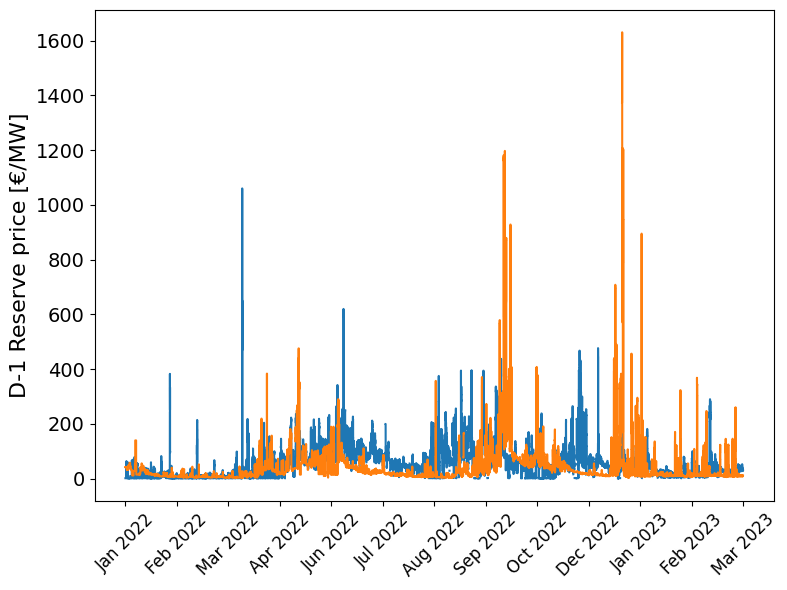

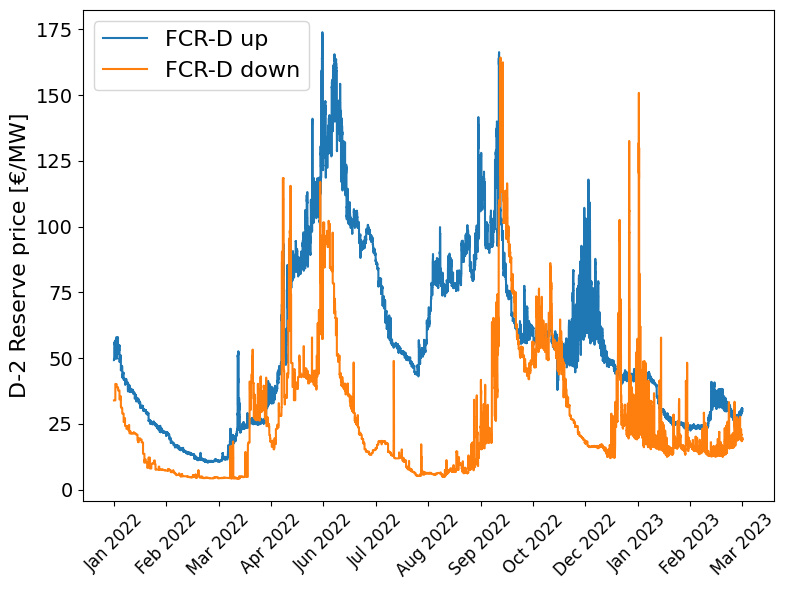

In [24]:
product_name = ["FCR-D upp", "FCR-D ned"]
product_name_label = ["FCR-D up", "FCR-D down"]
auction_type = ["D-1","D-2"]
price_areas = "DK2"




#fig, axs = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
for j, auction in enumerate(auction_type):
    fig, axs = plt.subplots(figsize=(8, 6), dpi=100)
    for i, product in enumerate(product_name):
    
        mask = (df["PriceArea"] == price_areas) & (df["AuctionType"] == auction) & (df["ProductName"] == product)
        price = df["PriceTotalEUR"].loc[mask]
        price = price.loc[::-1].reset_index(drop=True)
        axs.plot(price, label=f"{product_name_label[i]}", drawstyle='steps-post')
        axs.set_ylabel(f"{auction} Reserve price [\u20AC/MW]", fontsize=16)
        
    mask_total = (df["PriceArea"] == "DK2") & (df["AuctionType"] == "D-1") & (df["ProductName"] == product)
    xaxis = df["HourDK"].loc[mask_total]
    xaxis = xaxis.loc[::-1].reset_index(drop=True)
    xaxis = pd.to_datetime(xaxis)# Convert xaxis to datetime

    # Set the x-axis ticks to be monthly
    num_ticks = len(xaxis)
    tick_step = max(1, int(np.ceil(num_ticks / 12))) # Show at least one tick per month
    month_ticks = xaxis.index % tick_step == 0
    if not month_ticks[0]:
        month_ticks[0] = True
    if not month_ticks[-1]:
        month_ticks[-1] = True
    axs.set_xticks(xaxis.index[month_ticks])
    axs.set_xticklabels(xaxis[month_ticks].dt.strftime("%b %Y"), rotation=45, fontsize=12)
    if auction == "D-2":
        axs.legend(bbox_to_anchor=(0, 1), loc='upper left',prop={'size': 16})

    axs.tick_params(axis='y', which='major', labelsize=14)



    fig.tight_layout()
    plt.savefig('Prices_FCR-D_'+f"{auction}"+'.pdf', format="pdf", bbox_inches="tight")
    
